# **Diving Into Convolutions**

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle, gzip, math, os, time, shutil

import torch
from torch import nn, tensor
from torch .utils.data import default_collate, DataLoader
from typing import Mapping
from pathlib import Path

from miniai.training import * # Modules have already been developed in previous NBs
from miniai.datasets import * # and, reside in separate Github repo.

mpl.rcParams['image.cmap'] = 'gray'

In [5]:
# Data path, same as earlier NBs
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'

with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train, y_train, x_valid, y_valid= map(tensor, [x_train, y_train, x_valid, y_valid])

## **A Primer on Convolutions** (to do - prose)

In [3]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [10]:
# Storing training and validation datasets in tensors with new shapes to match the PIL form.
x_imgs = x_train.view(-1, 28, 28)
xv_imgs = x_valid.view(-1, 28, 28)

In [13]:
# Set output resolution
mpl.rcParams['figure.dpi'] = 40

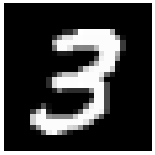

In [14]:
# Load a single image
im3 = x_imgs[7]
# Using the same show_image() function we created in nb_06
show_image(im3);

Let's create a 3x3 kernel to demonstrate how convolutions work.

For reference, [Wikipedia](https://en.wikipedia.org/wiki/Kernel_method) defines a Kernel method as: 

> Kernel methods owe their name to the use of kernel functions, which enable them to operate in a high-dimensional, implicit feature space without ever computing the coordinates of the data in that space, but rather by simply computing the inner products between the images of all pairs of data in the feature space. This operation is often computationally cheaper than the explicit computation of the coordinates. This approach is called the "kernel trick". Kernel functions have been introduced for sequence data, graphs, text, images, as well as vectors.



In [15]:
# Kernel to find / calculate values of top edges in image files
top_edge = tensor([[-1, -1, -1],
                   [ 0,  0,  0],
                   [ 1,  1,  1,]]).float()
top_edge

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

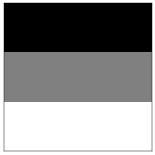

In [17]:
# Kernels can be visualized as well
show_image(top_edge, noframe=False);

Running a dot product on any window in our images, using this specific kernel can be illustrated as follows:

Imagine if ${A}$ is a window in any image:

$$
\mathbf{A} = \begin{bmatrix}
a_1 & a_2 & a_3 \\
a_4 & a_5 & a_6 \\
a_7 & a_8 & a_9
\end{bmatrix}
$$

and ${B}$ is the kernel matrix:

$$
\mathbf{B} = \begin{bmatrix}
-1 & -1 & -1 \\
0 & 0 & 0 \\
1 & 1 & 1
\end{bmatrix}
$$

The end result will be based on the following values:

$-a_1$  $-a_2$ $-a_3$ $a_7$ $a_8$ $+a_9$






In [23]:
# Grabbing the first 13 rows and 23 cols of the image and visualizing them for effect.
df = pd.DataFrame(im3[:13, :23])
df.style.format(precision=2).set_properties(**{'font-size': '10pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.17,0.41,1.00,0.99,0.99,0.99,0.99,0.99,0.68,0.02,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.54,0.88,0.88,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.62,0.05
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.70,0.98,0.98,0.98,0.98,0.99,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.23
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.98,0.98,0.90,0.52,0.52,0.52,0.52,0.74,0.98,0.98,0.98,0.98,0.23
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.11,0.11,0.09,0.00,0.00,0.00,0.00,0.05,0.88,0.98,0.98,0.67,0.03


Running a direct product on any 3x3 window and summing up will result in a large value.

In [25]:
# Take rows 3 to 5 and cols 14 to 16, multiply with the top_edge kernel and sum the results
(im3[3:6, 14:17] * top_edge).sum()

tensor(2.9727)

In [26]:
# Take rows 7 to 9 and cols 14 to 16, repeat the calculation
(im3[7:10, 14:17] * top_edge).sum()

tensor(-2.9570)

In [41]:
# Create a function which can replicate the calculation for any part of the image
def apply_kernel(row, col, kernel): return (im3[row-1:row+2, col-1:col+2] * kernel).sum()

In [42]:
# Apply kernel to the center of the grid
apply_kernel(4, 15, top_edge)

tensor(2.9727)

The kernel calculations needs to take place over a sliding window in this instance.

![title](imgs/3-3-kernel.png)

Another handy way of representing the sliding window calculations is to use a nested list comprehension, which happens to be a very handy idiom:



In [49]:
[[(i, j) for j in range(5)] for i in range(5)]

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

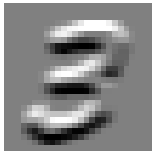

In [50]:
# Lets highlight the top edges, using a sliding window.
rng = range(1, 27) # dimensions
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])
show_image(top_edge3);

We can experiment with passing in a `left_edge` tensor as well.

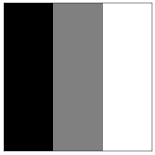

In [51]:
# Create left_edge tensor
left_edge = tensor([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]]).float()

show_image(left_edge, noframe=False);

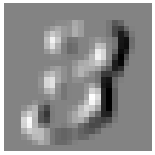

In [52]:
# Running the sliding window convolution from before
left_edge3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])
show_image(left_edge3);